In [1]:
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [4]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]
villes = sorted(villes, key=len)

In [5]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [6]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # account for <SOS> and <EOS>, which are appened at the beg. and end of each seq

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [9]:
def get_batch(split, batch_size):
    # returns a batch, according to the data pipeline written in the W&B report
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(high=data.shape[0], size=(1,), dtype=torch.int32).item() #sample la ligne seed autour de laquelle on va piocher les exemples

    if split == 'train':
        idx = torch.randint(low = max(0, idx_seed - 4 * batch_size), high = min(data.shape[0], idx_seed + 4 * batch_size), size=(batch_size,), dtype=torch.int32) #samples les indices du batch à produire
        
    else:
        start = max(0, idx_seed-batch_size/2)
        end =  min(data.shape[0]-1, idx_seed+batch_size/2)

        if end-start != batch_size:
            if start == 0:
                end = end - (idx_seed-batch_size/2 - start)
            else:
                start = start - (idx_seed+batch_size/2 - end)

        start, end = int(start), int(end)

        idx = torch.arange(start=start, end=end, dtype=torch.int64)
        
    #pq 4 ? bon compromis entre assez large pour pas bcp de répétitions, assez petit pour pas bcp de padding (cf data.ipynb)
    #en moyenne sur un batch, 6.7 d'écart en max_len et min_len (donc en moyenne pour une séq., 3,3 de padding) (ça fait bcp finalement? a comparer devant la longueur d'un mot) et max_len 17.8
    #longueur moyenne d'une séq. : 11.6. donc en moyenne pour une séq., on rajoute 28% de compute inutile...
    #on aura forcement pas mal de padding sur le val car dataset comparable devant 4*batch_size

    #pour 2, on aura 3.5 d'écart, donc 1.7 de padding
    # donc 14% de compute inutile par mot

    #pour 2, on a 12% des exemples qui sont des répétitions (122 pour un batch de 1024, en moyenne)
    #pour 4, seulement 6% (67 exemples)

    #pour batch_size=512
    #pour 2, 5% de répétitions, 1.8 de disp. donc 0.9 de padding (soit 7% de compute inutile par séq.)
    #pour 4, 3% de répétitions, 3.5 de disp. donc 1.7 de padding (soit 14% de compute inutile par séq.)

    #pour privilégier des données iid, je choisi de partir sur 4 (pour avoir des batch diversifiés, au détriment d'un peu de compute inutile)
    #voir considérer plus ?
    
    #pour le val. set, 4 semble bcp trop
    #pour 4, 12% de répétitions, 15 de disp. donc 7 de padding (soit plus de 50% de compute lost)
    #c'est dommage, vu qu'avoir des batchs diversifiés n'a aucun interet pour le calcul du loss, donc on ne fait que perdre du compute
    #mais le pb avec 1 (par exemple) c'est qu'on a enormément de répétitions (25%) au sein d'un batch... donc estimation du cout totalement erronée
    #je choisis d'adopter une stratégie un peu différente: sample idx_seed, et on prends tous les index entre idx_seed-batch_size/2 et idx_seed+batch_size/2

    idx_sorted, _ = torch.sort(idx) #on les ordonne pour recuperer facilement la longueur de la plus grande seq. du batch

    X_batch = data[idx_sorted] #on extrait la matrice qui va produire Xb et Yb

    max_len_batch = torch.sum(torch.ne(X_batch[-1], char_to_int['<pad>'])) #longueur de la plus grande seq. du batch : torch.ne(X_batch[-1], 0) crée une matrice masque, avec True si diff de 0, False si egal a 0

    Xb = X_batch[:, :max_len_batch-1] #on selectionne que jusqu'a la len max - 1 (<EOS> du plus long inutile) (le reste n'est que padding)
    Yb = X_batch[:, 1:max_len_batch] #meme que Xb, mais décalé de 1 (avec le <EOS> mais sans le <SOS>)

    #Xb[Xb == 1] = -1 #on remplace le <EOS> par du padding (totalement optionnel)

    Xb = Xb.pin_memory().to('cuda', non_blocking=True)
    Yb = Yb.type(torch.LongTensor).pin_memory().to('cuda', non_blocking=True)

    return Xb, Yb

#todo: mettre les shapes a cote

In [14]:
d_model = 64
mb_size = 32

In [61]:
Wu = torch.randn((44+d_model, d_model))/10
bu = torch.randn((d_model))/10

Wv = torch.randn((d_model, 44))/10
bv = torch.randn((44))/10

parameters = [Wu, bu, Wv, bv]

In [85]:
total_params = sum(p.numel() for p in parameters)
total_params

9836

In [62]:
for p in parameters:
    p.requires_grad = True

In [63]:
g = torch.Generator().manual_seed(42)
optim = torch.optim.AdamW(parameters, lr=0.0005, weight_decay=0.01, betas=(0.9, 0.99))

In [64]:
lossi = []

In [10]:
Xb, Yb = get_batch('train', 256)

In [12]:
X.shape

torch.Size([36567, 47])

In [106]:
for _ in range(1000):
    Xb, Yb = get_batch('train', 256)

    #forward
    loss = 0
    S = torch.ones((mb_size, d_model)) # (32, d_model)
    
    for t in range(0, Xb.shape[1]-1):
        W_t = Xb[:, t] # (32, 44) #TODO : embed avant de passer par W (relire papier)
        
        X_t = torch.cat([W_t, S], dim=1) # (32, 44+d_model)

        S = F.tanh(X_t @ Wu + bu) # (32, d_model)

        logits = S @ Wv + bv # (32, 44)

        targets = torch.argmax(X[len_mb][ix_mb, t+1, :], dim=1)
        loss += F.cross_entropy(logits, targets)

    loss = loss / (len_mb - 1)
    lossi.append(loss.log10().item())

    optim.zero_grad()
    loss.backward()
    optim.step()

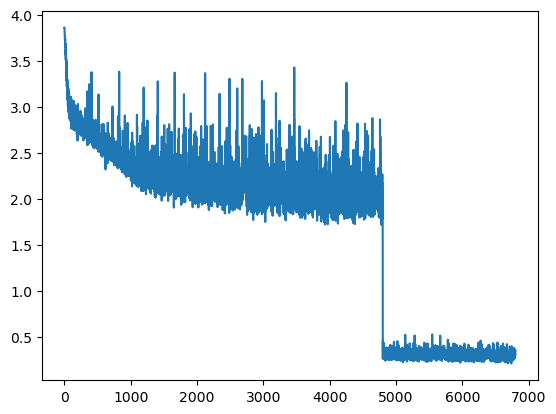

In [107]:
plt.plot(lossi)

In [111]:
total_loss = 0
total_seq_len = 0

with torch.no_grad():  # Pas besoin de calculer les gradients lors de l'évaluation
    for len_mb, tensor in X.items():  # Ici, je suppose que X est votre dataset d'entraînement
        for ix_mb in range(tensor.shape[0]):
            loss = 0
            S = torch.ones((1, d_model))  # Ici, le mini-batch a une taille de 1
            for t in range(0, len_mb-1):
                W_t = tensor[ix_mb:ix_mb+1, t, :]  # Récupère un sous-ensemble de taille 1 du mini-batch
                
                X_t = torch.cat([W_t, S], dim=1) 

                S = F.tanh(X_t @ Wu + bu) 

                logits = S @ Wv + bv 

                targets = torch.argmax(tensor[ix_mb:ix_mb+1, t+1, :], dim=1)
                loss += F.cross_entropy(logits, targets)
            
            total_loss += loss.item()
            total_seq_len += len_mb - 1  # Compte le nombre total de pas de temps

totalloss = total_loss / total_seq_len

In [112]:
totalloss

1.986338191039846

In [113]:
#sampling

g = torch.Generator().manual_seed(40 + 2)

for _ in range(10):

    nom = ""

    #forward
    S = torch.ones((1, d_model)) # (1, d_model)
    W_t = F.one_hot(torch.tensor(0), num_classes=44).view(1, 44)

    while True:
        X_t = torch.cat([W_t, S], dim=1) # (1, 44+d_model)

        S = F.tanh(X_t @ Wu + bu) # (1, d_model)

        logits = S @ Wv + bv # (1, 44)
        Y_t = F.softmax(logits, dim=1)

        next_id = torch.multinomial(Y_t, num_samples=1, replacement=True, generator=g).item()

        if next_id == 0:
            break

        W_t = F.one_hot(torch.tensor(next_id), num_classes=44).view(1, 44)
        nom += int_to_char[next_id]
    
    print(nom)

valladet
counsain-le-chédagne
borstay
ethaboin
iellafze
vaybey-mère
chaugly
attard
la jauziclonseine
le raudien
